In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Configurações do pandas
pd.set_option('display.max_columns', None)

In [2]:
# Carregar os dados de vendas
hist = pd.read_csv('./data/vendas.csv')
hist

,sku,data_venda,venda
0,336,2024-01-14,15
1,336,2024-01-18,28
2,336,2024-01-20,34
3,336,2024-01-23,32
4,336,2024-01-25,27
...,...,...,...
135221,2883,2024-02-11,12
135222,4593,2024-02-13,23
135223,774,2024-02-13,25
135224,2580,2024-02-13,16


In [3]:
hist['data_venda'] = pd.to_datetime(hist['data_venda'])  # Converter a coluna de data para datetime

# Criar um DataFrame com todas as datas no intervalo de vendas
datas = pd.DataFrame({'data_venda': pd.date_range(start=hist['data_venda'].min(), end=hist['data_venda'].max()), 'key': 1})

# Criar um DataFrame com todos os SKUs únicos
prods = pd.DataFrame({'sku': hist['sku'].unique(), 'key': 1})

# Fazer merge para obter todos os SKUs para cada data
hist_ajustado = pd.merge(prods, datas, on='key', how='left').drop(columns='key')

# Fazer merge com os dados históricos de vendas e preencher valores nulos com 0
df = pd.merge(hist_ajustado, hist, on=['sku', 'data_venda'], how='left').fillna(0)

# Remover DataFrames temporários para liberar memória
del datas, prods, hist_ajustado

In [4]:
# Definindo as datas para treino e teste
treino_inicio_desenvolvimento = '2024-01-14'
treino_fim_desenvolvimento = '2024-03-24'
teste_inicio_desenvolvimento = '2024-01-21'
teste_fim_desenvolvimento = '2024-03-31'
treino_performance = '2024-03-31'
teste_performance = '2024-04-07'

# Renomeando as colunas para o formato esperado pelo Prophet
df.rename(columns={'data_venda': 'ds', 'venda': 'y'}, inplace=True)

In [5]:
# Função para aplicar Prophet a cada SKU
def forecast_sku(train_data, periods=7):
    model = Prophet()
    model.fit(train_data)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Dicionário para armazenar previsões
forecasts = {}

# Loop através de cada SKU para gerar previsões
for sku in df['sku'].unique():
    sku_data = df[df['sku'] == sku]
    
    # Dividir dados em treino e teste
    train_data = sku_data.iloc[:-14]  # Todos os dados menos os últimos 14 dias
    test_data = sku_data.iloc[-14:]    # Últimos 14 dias para comparação

    # Fazer previsões para os próximos 14 dias
    forecast = forecast_sku(train_data, periods=14)
    
    # Adicionar coluna do SKU às previsões
    forecast['sku'] = sku
    
    # Separar previsões nos últimos 14 dias em treino simulado e teste
    forecast_train_simulated = forecast.iloc[-14:-7]  # Simulado para comparação
    forecast_test = forecast.iloc[-7:]                # Teste real

    # Armazenar previsões no dicionário
    forecasts[sku] = {
        'simulated_train': forecast_train_simulated.assign(type='simulated_train'),
        'test': forecast_test.assign(type='test')
    }

18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:56 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:57 - cmdstanpy - INFO - Chain [1] done processing
18:01:57 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing
18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing
18:01:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1]

In [6]:
# Concatenar todos os dataframes de previsões em um único DataFrame final
final_forecast_df = pd.concat([forecasts[sku]['simulated_train'] for sku in forecasts] + 
                               [forecasts[sku]['test'] for sku in forecasts], 
                               ignore_index=True)

# Exibir o DataFrame final
final_forecast_df

,ds,yhat,yhat_lower,yhat_upper,sku,type
0,2024-03-26,15.646217,8.628721,23.507051,336,simulated_train
1,2024-03-27,17.344272,10.123825,25.085518,336,simulated_train
2,2024-03-28,16.644613,9.256622,23.689593,336,simulated_train
3,2024-03-29,20.141000,12.478237,27.377015,336,simulated_train
4,2024-03-30,27.733511,20.492558,35.096973,336,simulated_train
...,...,...,...,...,...,...
79739,2024-04-04,0.928922,-0.567713,2.577973,2754,test
79740,2024-04-05,-0.169255,-1.653756,1.271033,2754,test
79741,2024-04-06,-0.169254,-1.672180,1.454093,2754,test
79742,2024-04-07,-0.182273,-1.760032,1.322958,2754,test


In [7]:
# Realiza o merge entre os resultados e as previsões
results = df.loc[df['ds'] >= '2024-03-26'].merge(final_forecast_df, on=['sku', 'ds'], how='left').copy()

# Filtra os resultados para o intervalo de interesse e agrupa por SKU, somando as vendas reais e previstas
grouped_results = results.loc[(results['ds'] >= '2024-03-26') & (results['ds'] <= '2024-04-01')].groupby('sku')[['y', 'yhat']].sum().reset_index()

# Agrupa os resultados do período de teste, somando as vendas reais e previstas
grouped_results_test = results.loc[(results['ds'] >= '2024-04-02') & (results['ds'] <= '2024-04-08')].groupby('sku')[['y', 'yhat']].sum().reset_index()

In [8]:
# Renomeia as colunas para um formato mais compreensível
performance_final = grouped_results_test.rename(columns={'y': 'venda', 'yhat': 'previsao'}).copy()

# Calcula a diferença entre a previsão e a venda real
performance_final['erro'] = performance_final['previsao'] - performance_final['venda']

# Calcula o erro percentual
performance_final['erro_percentual'] = performance_final['previsao'] / performance_final['venda']

In [9]:
# Classifica a venda em categorias de volume
performance_final['categoria_volume'] = pd.cut(
    performance_final['venda'],
    bins=[-1, 0, 10, 100, float('inf')],
    labels=['Zero', 'Baixo', 'Médio', 'Alto']
)

# Calculando MAE (Mean Absolute Error) por categoria de volume
mae_por_volume = performance_final.groupby('categoria_volume', observed=False).apply(lambda x: np.mean(np.abs(x['previsao'] - x['venda'])), include_groups=False)
print("MAE por categoria de volume:\n", mae_por_volume)

MAE por categoria de volume:
 categoria_volume
Zero     14.104863
Baixo    22.707100
Médio    43.006144
Alto     87.133098
dtype: float64


In [10]:
# Calculando MAE percentual por categoria de volume
mae_por_volume_percentual = performance_final.groupby('categoria_volume', observed=False).apply(lambda x: np.mean(np.abs(x['erro_percentual'])), include_groups=False)
print("MAE percentual por categoria de volume:\n", mae_por_volume_percentual)

MAE percentual por categoria de volume:
 categoria_volume
Zero          inf
Baixo    2.147704
Médio    1.517841
Alto     0.965580
dtype: float64


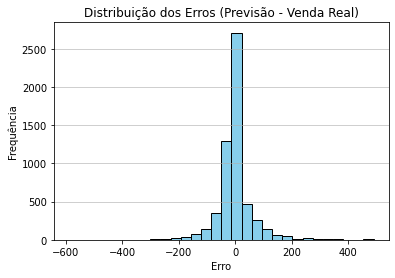

In [11]:
# Plotando a distribuição dos erros
plt.hist(performance_final['erro'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Erros (Previsão - Venda Real)')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

c:\Users\rafae\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


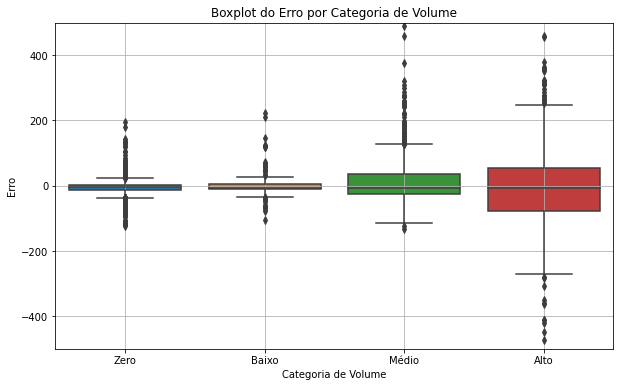

In [12]:
# Criando um boxplot para visualizar os erros por categoria de volume
plt.figure(figsize=(10, 6))
# Filtra os dados para evitar outliers que podem distorcer a visualização
sns.boxplot(x='categoria_volume', y='erro', data=performance_final.loc[performance_final['venda'] < 2000])
plt.title('Boxplot do Erro por Categoria de Volume')
plt.xlabel('Categoria de Volume')
plt.ylabel('Erro')
plt.grid(True)
plt.ylim(-500, 500)
plt.show()

In [13]:
mean_absolute_error(performance_final['venda'], performance_final['previsao'])

36.336837225496645

In [37]:
def forecast_venda(sku):
    # Filtra o DataFrame para encontrar o SKU específico
    previsao = performance_final.loc[performance_final['sku'] == sku, 'previsao']
    
    # Verifica se a previsão foi encontrada
    if not previsao.empty:
        return "A previsão de venda do produto {} na próxima semana é {:.2f}".format(sku, previsao.iloc[0])
    else:
        return "SKU {} não encontrado no conjunto de dados.".format(sku)

In [23]:
previsoes = final_forecast_df.loc[(final_forecast_df['ds'] >= '2024-04-02') & (final_forecast_df['ds'] <= '2024-04-08')][['sku', 'ds', 'yhat']].copy()

In [27]:
comparativo_previsao = df.merge(previsoes, on=['sku', 'ds'], how='left').copy()
comparativo_previsao.loc[comparativo_previsao['yhat'].isnull(), 'yhat'] = comparativo_previsao.loc[comparativo_previsao['yhat'].isnull()]['y']

In [29]:
comparativo_previsao.rename(columns={'ds': 'data_venda', 'y': 'venda', 'yhat': 'previsao'}, inplace=True)

In [32]:
def plot_comparativo_vendas(sku):
    """
    Gera um gráfico comparativo entre as vendas reais e as previsões para um SKU específico.
    
    Parâmetros:
        sku (str): O SKU do produto para o qual o gráfico será gerado.
    """
    # Filtrar o DataFrame para o SKU especificado
    df_sku = comparativo_previsao[comparativo_previsao['sku'] == sku]

    # Verificar se o SKU existe no DataFrame
    if df_sku.empty:
        print(f"SKU {sku} não encontrado no conjunto de dados.")
        return

    # Configurar o tamanho da figura
    plt.figure(figsize=(10, 5))

    # Plotar as vendas reais e previstas
    plt.plot(df_sku['data_venda'], df_sku['venda'], label='Venda Real', marker="o", color="blue")
    plt.plot(df_sku['data_venda'], df_sku['previsao'], label='Previsão', marker="o", color="red")

    # Configurações do gráfico
    plt.title(f'Comparação entre Vendas Reais e Previsões para SKU: {sku}', fontsize=16)
    plt.xlabel("Data de Venda")
    plt.ylabel("Vendas")
    plt.legend()
    plt.tight_layout()

    # Exibir o gráfico
    plt.show()

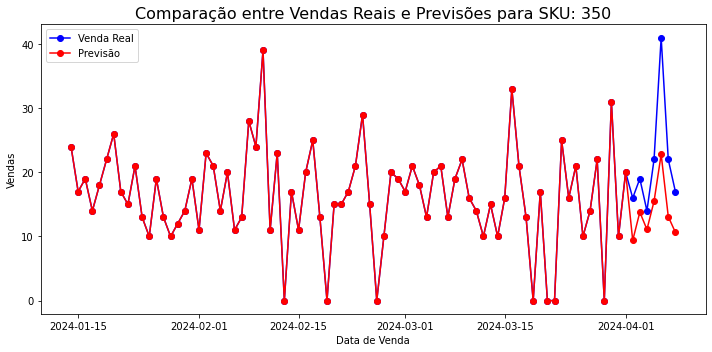

In [34]:
plot_comparativo_vendas(350)

In [38]:
forecast_venda(350)

'A previsão de venda do produto 350 na próxima semana é 96.30'